In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import hexMinisom
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
import pickle
from sammon import sammon
import itertools
import igraph as ig
import colorsys
import random
import datetime as dt

### Dataset

In [2]:
dataset = xr.open_dataarray('data/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

# Seasonal breakdown of the data
DJF = dataset.time.dt.month.isin([12, 1, 2])
DJF_idxs = np.array(DJF).nonzero()[0]
MAM = dataset.time.dt.month.isin([3, 4, 5])
MAM_idxs = np.array(MAM).nonzero()[0]
JJA = dataset.time.dt.month.isin([6, 7, 8])
JJA_idxs = np.array(JJA).nonzero()[0]
SON = dataset.time.dt.month.isin([9, 10, 11])
SON_idxs = np.array(SON).nonzero()[0]

print(dataarray.shape)

(30660, 9211)


### Load in SOM

In [3]:
def save_som(som, fileName):
    with open(fileName, 'wb') as outfile:
        pickle.dump(som, outfile)

def load_som(fileName):
    with open(fileName, 'rb') as infile:
        som = pickle.load(infile)

    return som

som = load_som('pickles/SOM40.p')

n = som._num
xy = hexMinisom.xy_using_n(n)

mask = som._mask
node_indices_xy = np.ma.where(mask == False)
node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))
all_nodes = product(range(xy), range(xy))

inputLength = dataarray.shape[1]

winmap = som.win_map(dataarray, return_indices=True)

w = som._weights
minimum_weight = -np.max(np.abs(w))
maximum_weight = np.max(np.abs(w))

# Calculate the node number for each coordinate
node_nums = {}
n = 1
for i in range(mask.shape[0])[::-1]:
    for j in range(mask.shape[1]):
        # only use non masked nodes
        if som._mask[i, j] == 0:
            node_nums[(i, j)] = n
            n += 1


def generate_distinct_colors(n):
    colors = []
    
    # Generate `n` distinct colors in the HSV color space
    for i in range(n):
        # Generate a unique hue for each color, evenly spaced between 0 and 1
        hue = i / n
        # Use full saturation and value to get vibrant colors
        saturation = 1.0
        value = 1.0
        
        # Convert HSV to RGB (the result is a tuple of RGB values in [0, 1])
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        
        # Convert RGB to a format that ranges from 0 to 255 and create a hex string
        rgb = [int(x * 255) for x in rgb]
        hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        
        colors.append(hex_color)

    random.shuffle(colors)

    return colors

color_list = generate_distinct_colors(len(node_indices))

### Useful SOM features

### Base plotting functions

In [4]:
# Plotting functions
def hex_heatmap(som, data, cmap='Blues', title='', cbLabel=''):
    # set up the figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    cmap = mpl.colormaps[cmap]
    
    # get data from the som
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    
    maxCount = max(v for v in data.values())
    #maxCount = 553  #frequency
    #maxCount = 4.39   #persistence
    minCount = min(v for v in data.values())
    #minCount = 65    #frequency
    #minCount = 1.23   #persistence
    
    # loops through the neurons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            # Only use non-masked nodes
            if som._mask[i, j] == 0:
                # If theres no data still plot the hexagon
                if (i, j) not in data:
                    data[(i,j)] = 0
                    
                # determine the hexagon position and color
                wy = yy[(j, i)] * np.sqrt(3) / 2
                colorWeight = data[(i, j)]/maxCount
                
                # Create hexagon and add it to axis
                hex = patches.RegularPolygon((xx[(j, i)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                        facecolor=cmap(colorWeight), edgecolor='grey')
                ax.add_patch(hex)
                
                # determine the color the text should be based on color of node
                if colorWeight >= .75:
                    textColor = 'white'
                else:
                    textColor = 'black'
                
                # add text to hexagon for its frequency
                plt.text(xx[(j, i)], wy - .05, f'{data[(i, j)]}', {'horizontalalignment': 'center', 'color': textColor, 'fontsize': 12})
            
    # align figure to show all hexagons
    plt.xlim(-1, weights.shape[0] - .5)
    plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    
    # remove the axis labels and lines
    ax.axis('off')
    
    # Create the color bar
    norm = mpl.colors.Normalize(vmin=minCount, vmax=maxCount)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=.7)
    cb.set_label(cbLabel)
    
    # Title the plot
    plt.title(title, fontsize=20, y=.95, x=.515)
    
    return fig

def hex_frequency_plot(som, winmap=None):

    if winmap == None:
        winmap = som.win_map(dataarray)
    
    data = {k: len(v) for k, v in winmap.items()}
    
    fig = hex_heatmap(som, data, 'Blues', '(a) SOM Node Frequencies', 'Count')

    return fig

def hex_plot(som, projection=None):
    """Create a matplot lib figure with an axis for each neuron already positioned into the hexagonal shape"""
    
    # Extract the needed data from the som
    n = som._num
    xy = (2 * n) - 1
    mask = som._mask
    node_indices_xy = np.ma.where(mask == False)
    node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))

    # create figure
    totRows = xy * 3
    totCols = xy * 2
    fig = plt.figure(figsize=[totRows, totCols])
    axs = {}
    
    for x, y in list(product(range(xy), range(xy))):

        # make a subplot for the nodes not masked
        if (y, x) in node_indices: # for showing in the proper orientation x and y must be switched
            
            # odd rows will be offset to keep the hexagonal shape
            if y % 2 == 0:
                curRow = x * 3
            else:
                curRow = (x * 3) + 1
                
            curCol = (totCols - 2) - (y * 2)

            ax = plt.subplot2grid((totCols, totRows), (curCol, curRow), rowspan=2, colspan=2, projection=projection)
            ax.set_title(node_nums[(y, x)])
            
            if projection is not None:
                ax.set_extent([-180, -30, 20, 80], crs=projection)
        
            axs[(y, x)] = ax
        
    return fig, axs

def hex_composite_map(som, winmap=None, somAvgs=None):
    
    
    fig, axs = hex_plot(som, projection=ccrs.PlateCarree())

    lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
    lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
    lons, lats = np.meshgrid(lons, lats)
    
    if winmap == None:
        winmap = som.win_map(dataarray, return_indices=True)
    neurons = list(winmap.keys())

    for neuron in neurons:
        avgs = np.array(w[neuron[0], neuron[1], :]).reshape((lons.shape[0], lats.shape[1]))

        axs[neuron[0], neuron[1]].pcolor(lons, lats, avgs, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=ccrs.PlateCarree())
        
        axs[neuron[0], neuron[1]].set_title(f"Sample size: {len(winmap[(neuron[0], neuron[1])])}: {(neuron[0], neuron[1])})", fontsize=12)
        
        # background map features
        axs[neuron[0], neuron[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
        axs[neuron[0], neuron[1]].margins(x=0, y=0)
        axs[neuron[0], neuron[1]].add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
        axs[neuron[0], neuron[1]].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

    return fig

#### Season breakdown for winmap

In [5]:
DJF_winmap = {}
MAM_winmap = {}
JJA_winmap = {}
SON_winmap = {}

# Loop through each node
for k, v in winmap.items():
    
    # Keep only the days that are in the given season
    DJF_winmap[k] = [i for i in v if i in DJF_idxs]
    MAM_winmap[k] = [i for i in v if i in MAM_idxs]
    JJA_winmap[k] = [i for i in v if i in JJA_idxs]
    SON_winmap[k] = [i for i in v if i in SON_idxs]

Text(0.5, 0.93, 'Composites for all Seasons')

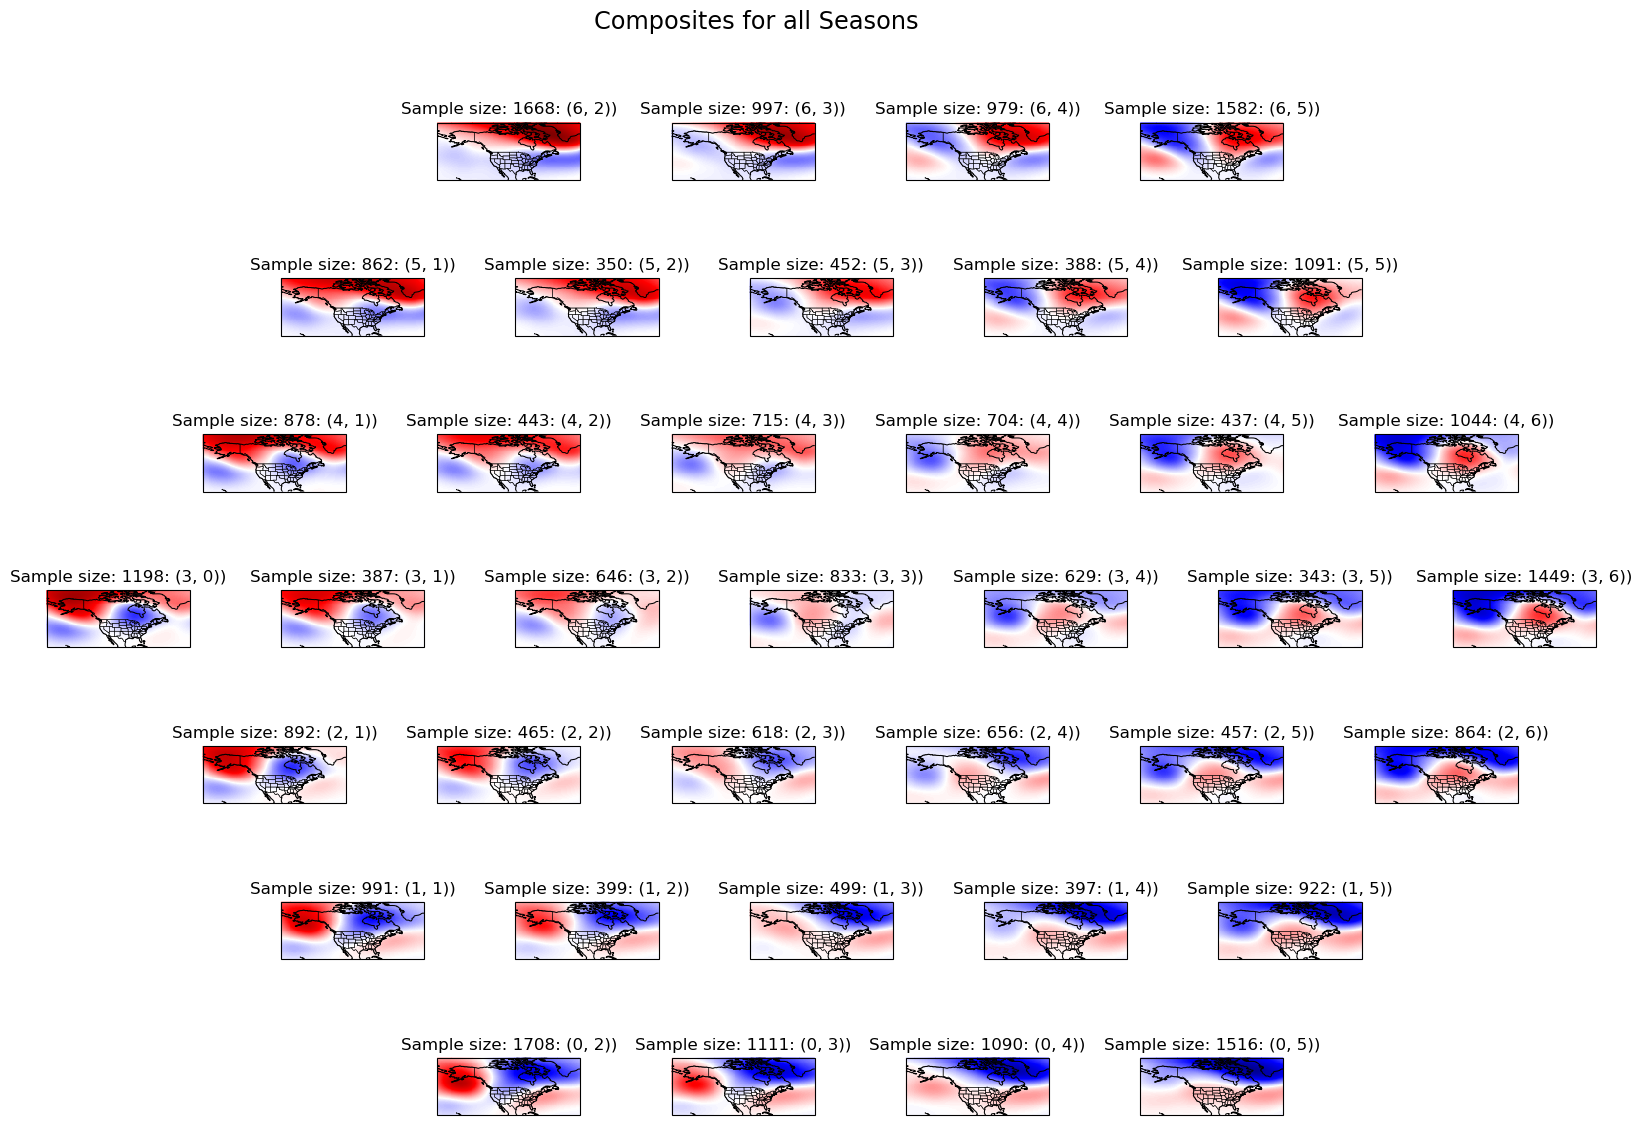

In [7]:
# Composite plots
c = hex_composite_map(som, winmap=winmap)
plt.suptitle('Composites for all Seasons', y=.93, fontsize='xx-large')

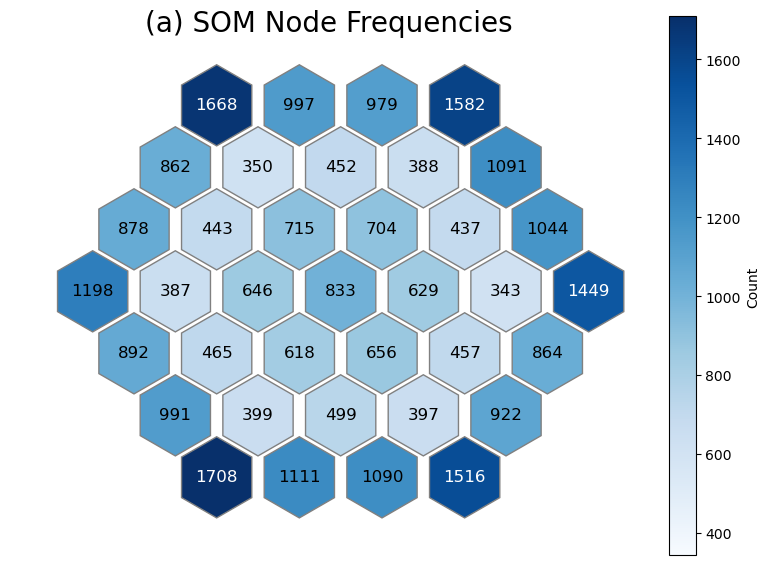

In [65]:
# Frequency plot
p = hex_frequency_plot(som, winmap=winmap)
p.savefig('pdf_output/SOM_frequencies.pdf')

### Persistance plots

In [5]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in winmap:
    idxs = np.array(winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}

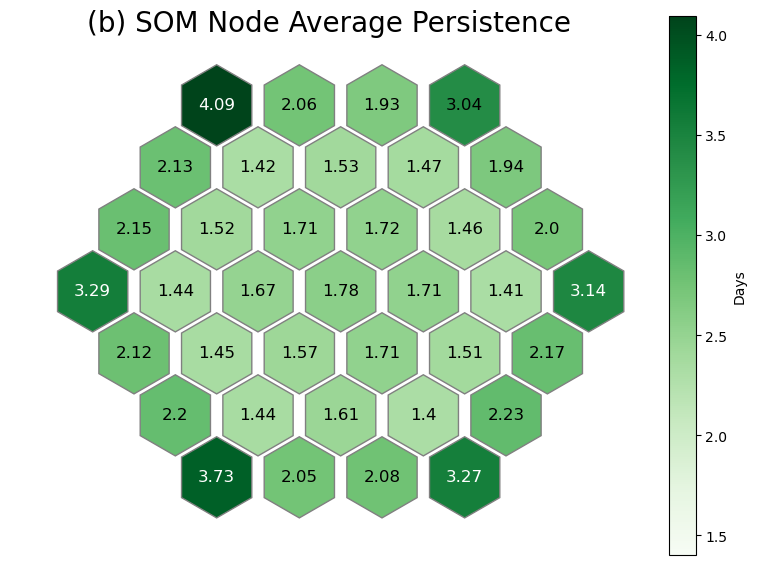

In [36]:
fig = hex_heatmap(som, averagePersistences, 'Greens', '(b) SOM Node Average Persistence', 'Days')
plt.savefig('pdf_output/SOM_persistences.pdf')

In [ ]:
# Combined frequency and persistence heatmap plots
fig = hex_frequency_plot(som, winmap)


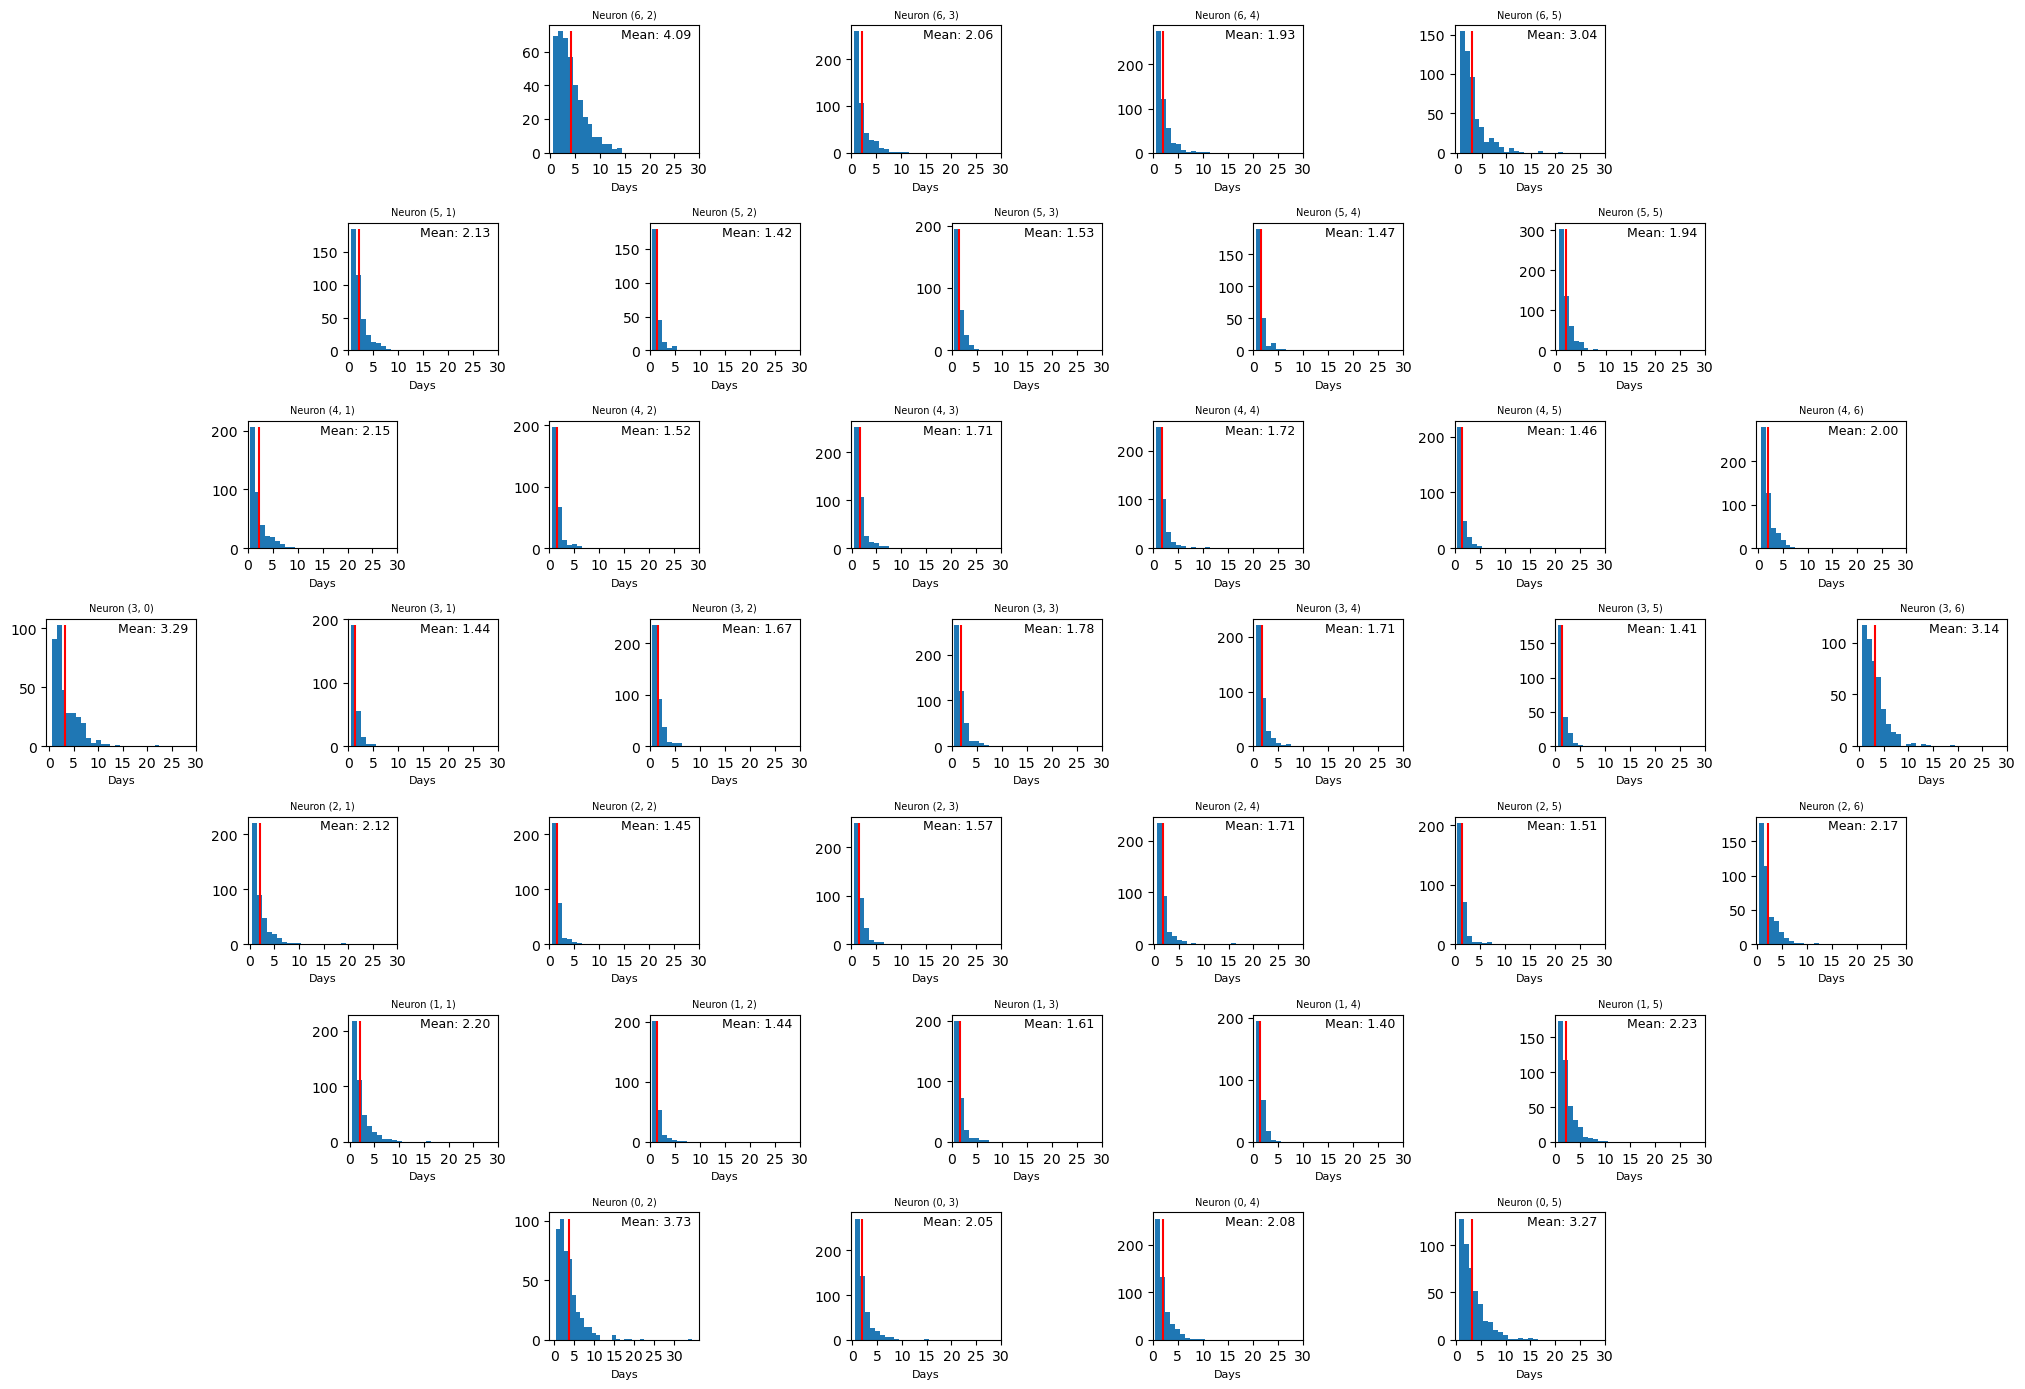

In [11]:
fig, axs = hex_plot(som)

# Find the longest stretch of a consistant regime 
maxDays = max(regimePersistences.values(), key=lambda x: x[0][-1])[0][-1]

for node in node_indices:
    ax = axs[node[0], node[1]]
    numDays, count = regimePersistences[node]
    
    mean = sum(numDays * count) / sum(count)

    ax.bar(numDays, count, width=1)
    ax.vlines(mean, 0, max(count), label='Mean', color='red')
    ax.text(.95, .9, f'Mean: {mean:.2f}', fontsize=9, horizontalalignment='right', transform=ax.transAxes)
    ax.set_xlabel('Days', fontsize=8)
    ax.xaxis.set_ticks(np.arange(0, maxDays, 5))
    ax.set_title(f'Neuron {node}', fontsize=7)
    
fig.tight_layout()
plt.show()

## Weather Regime Diversity

In [6]:
# Import the regime labels
WR_labels_df = pd.read_csv('data/df_labels_nocorrfilt_ERA5.csv')
WR_labels_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
WR_labels_df['date'] = pd.to_datetime(WR_labels_df['date'], format='%Y-%m-%d')
WR_labels_dict = {0: 'Polar High', 1: 'Pacific Trough', 2: 'Pacific Ridge', 3: 'Alaskan Ridge', 4: 'Atlantic Ridge', 5: 'No WR'}
WR_labels = np.array(WR_labels_df['WR'])

# Get the counts of each WR_label for each node in SOM
def get_WR_counts(l, return_percents=False, indices=None):

    # Take only the data from days with the given indices in indices
    if indices is None:
        labels, counts = np.unique([WR_labels[i] for i in l], return_counts=True)
    else:
        labels, counts = np.unique([WR_labels[i] for i in l if i in indices], return_counts=True)

    # If the node has no days of a given regime add the regime to the labels and 0 as its count
    if len(labels) != len(WR_labels_dict.keys()):
        missing_values = np.setdiff1d(list(WR_labels_dict.keys()), labels)

        labels = WR_labels_dict.keys()

        for v in missing_values:
           counts = np.insert(counts, v, 0)

    # Calculate the percents
    if return_percents:
        counts = 100 * counts / sum(counts)

    regime_counts = dict(zip(labels, counts))

    return regime_counts

WRs_by_node = {k: get_WR_counts(v) for k, v in winmap.items()}
WRs_percents = {k: get_WR_counts(v, return_percents=True) for k, v in winmap.items()}

print(WR_labels_df)

            date  WR  distances      corr
0     1940-01-01   0   2.463938  0.518457
1     1940-01-02   0   2.662645  0.565398
2     1940-01-03   0   2.916932  0.552532
3     1940-01-04   0   3.122750  0.495652
4     1940-01-05   0   3.302769  0.394692
...          ...  ..        ...       ...
30655 2023-12-27   1   2.823370  0.857459
30656 2023-12-28   1   2.687266  0.837698
30657 2023-12-29   1   2.394127  0.781903
30658 2023-12-30   1   2.253624  0.655454
30659 2023-12-31   0   2.468174  0.359541

[30660 rows x 4 columns]


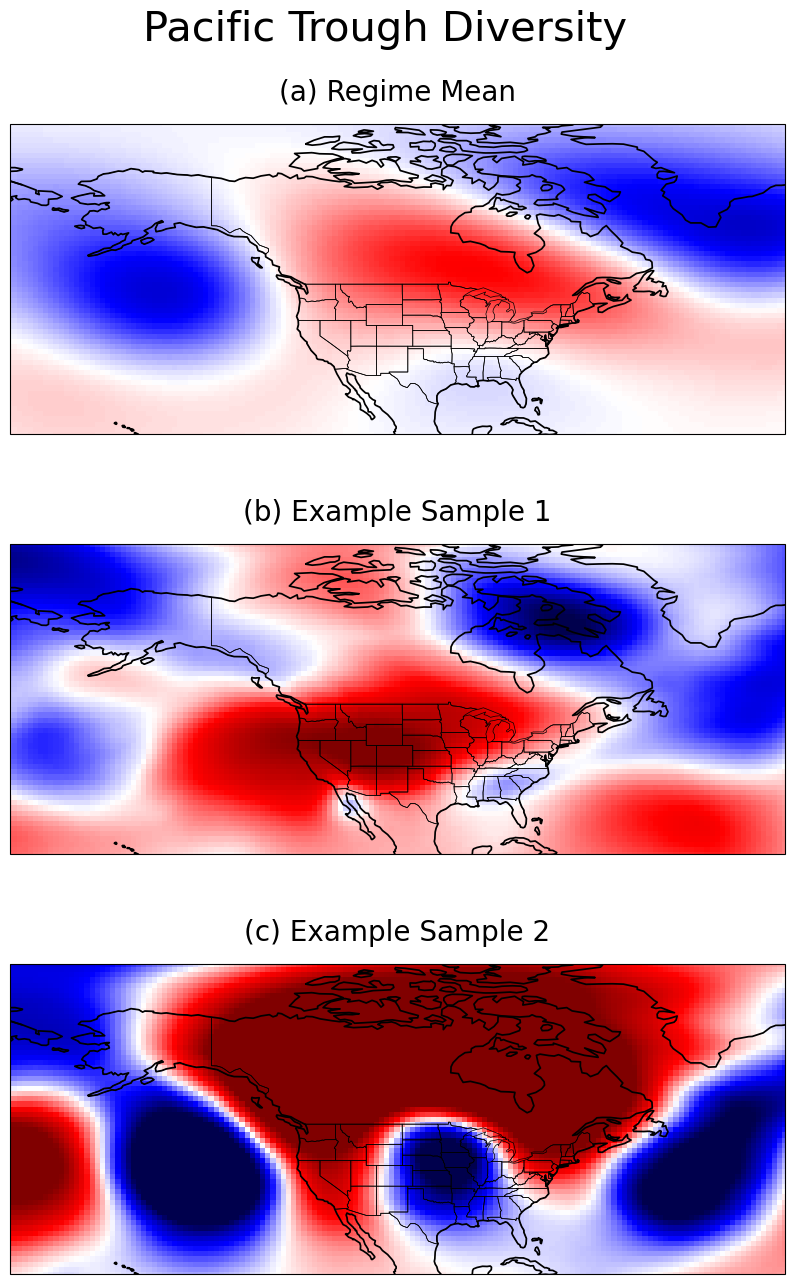

In [24]:
wr = 1

# Set up our lats and lons
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
lons, lats = np.meshgrid(lons, lats)

# get the closest and furthest distance days
closest = min(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
furthest = max(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
cidx = WR_labels_df[WR_labels_df['distances'] == closest].index[0]
fidx = WR_labels_df[WR_labels_df['distances'] == furthest].index[0]
cdata = dataarray[cidx].reshape((lons.shape[0], lats.shape[1]))
fdata = dataarray[fidx].reshape((lons.shape[0], lats.shape[1]))

# get the regime mean
wr_idxs = np.array(WR_labels == wr).nonzero()[0]
regime_mean = np.mean(dataarray[wr_idxs], axis=0).reshape((lons.shape[0], lats.shape[1]))

# Set up our figure
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 20))
axs = []

axs.append(plt.subplot2grid((3, 1), (0, 0), 1, 1, projection=proj))
axs.append(plt.subplot2grid((3, 1), (1, 0), 1, 1, projection=proj))
axs.append(plt.subplot2grid((3, 1), (2, 0), 1, 1, projection=proj))

# set up the background for each of the plots
for ax in axs:
    ax.set_extent([-180, -30, 20, 80], crs=proj)
    ax.coastlines(resolution='110m', color='k', linewidth=1.25, zorder=10)
    ax.margins(x=0, y=0)
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.5, zorder=10)
    ax.add_feature(cf.BORDERS, linewidth=0.5, zorder=10)

axs[0].pcolor(lons, lats, regime_mean, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[0].set_title(f'(a) Regime Mean', fontsize=20, y=1.05)
axs[1].pcolor(lons, lats, cdata, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[1].set_title(f'(b) Example Sample 1', fontsize=20, y=1.05)
axs[2].pcolor(lons, lats, fdata, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[2].set_title(f'(c) Example Sample 2', fontsize=20, y=1.05)

plt.suptitle('Pacific Trough Diversity', y=.84, fontsize=30)
plt.subplots_adjust(hspace=-.4)

plt.show()

In [27]:
print(WR_labels_df.iloc[cidx-10:cidx+10])
print(WR_labels_df.iloc[fidx-10:fidx+10])

            date  WR  distances      corr
21508 1998-12-05   2   2.847915  0.318290
21509 1998-12-06   2   2.790247  0.305583
21510 1998-12-07   2   2.757003  0.299197
21511 1998-12-08   1   2.810120  0.118166
21512 1998-12-09   1   2.805652  0.339590
21513 1998-12-10   1   2.884572  0.473837
21514 1998-12-11   1   2.872625  0.547330
21515 1998-12-12   1   2.634241  0.592416
21516 1998-12-13   1   2.138400  0.626748
21517 1998-12-14   1   1.509607  0.645714
21518 1998-12-15   1   1.219359  0.539465
21519 1998-12-16   5   1.543435       NaN
21520 1998-12-17   5   2.169627       NaN
21521 1998-12-18   3   2.838697  0.296929
21522 1998-12-19   3   3.257812  0.310364
21523 1998-12-20   3   3.483051  0.322300
21524 1998-12-21   3   3.494489  0.340271
21525 1998-12-22   3   3.384896  0.362371
21526 1998-12-23   3   3.320368  0.374814
21527 1998-12-24   3   3.429475  0.360375
            date  WR  distances      corr
11243 1970-10-21   4   3.590241  0.362826
11244 1970-10-22   5   3.834307   

#### Distances Histogram

In [9]:
wr_colors = sns.color_palette('muted')
indicies = [0, 1, 2, 3, 6, 7]
wr_colors = [wr_colors[i] for i in indicies]

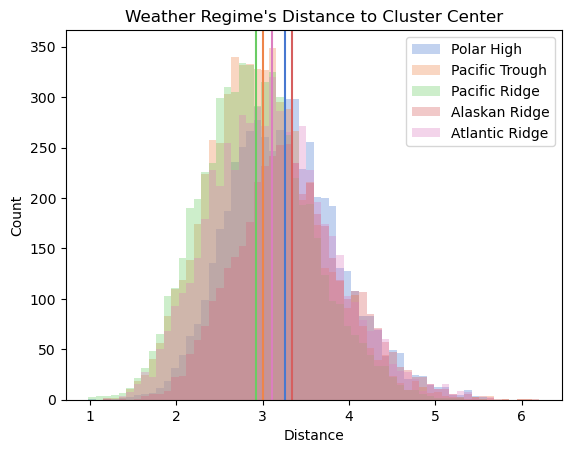

In [11]:
dists = WR_labels_df['distances']
wr_dists = {}

# Split up the distances by WR
for wr in np.unique(WR_labels_df['WR']):
    
    # Don't include no WR regime
    if wr != 5:
        i = np.where(WR_labels_df['WR'] == wr)[0]
        wr_dists[wr] = dists[i]
    
num_bins = 60
bin_min = min(dists)
bin_max = max(dists)

# Plot each WR distance histogram
for k, v in wr_dists.items():
    
    plt.hist(v, num_bins, (bin_min, bin_max), alpha=1/(len(wr_dists.keys()) - 2), color=wr_colors[k], label=WR_labels_dict[k])
    avg = np.mean((v))
    plt.axvline(avg, color= wr_colors[k])

plt.title('Weather Regime\'s Distance to Cluster Center')
plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('Distance')

plt.show()

In [25]:
m = min(WR_labels_df['distances'])
print(m)
print(WR_labels_df[WR_labels_df['distances'] == m].index[0])
print(WR_labels_df[WR_labels_df['distances'] == m])

0.9809302315002808
26122
            date  WR  distances     corr
26122 2011-07-27   2    0.98093  0.80267


#### Visualization of distribution tails

In [17]:
def get_random_tail_sample(wr, std=1, samples=1):
    regime = wr_dists[wr]

    non_tail_idx = regime[regime >= 1.3].index #(np.mean(regime) + std * np.std(regime))].index
    regime_tail = regime.drop(non_tail_idx)
    
    s = regime_tail.sample(n=samples)
    
    return np.array(list(zip(s.index, s)))
    
sample = get_random_tail_sample(3, 1)
print(sample)

[[1.23100000e+03 1.18637943e+00]]


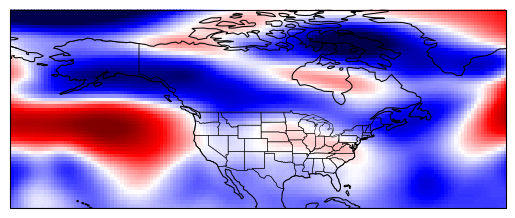

In [23]:
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
lons, lats = np.meshgrid(lons, lats)

s_data = dataarray[WR_labels_df[WR_labels_df['distances'] == m].index[0]]
s_data = s_data.reshape((lons.shape[0], lats.shape[1]))


proj = ccrs.PlateCarree()


fig = plt.figure()
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([-180, -30, 20, 80], crs=proj)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
        
ax.pcolor(lons, lats, s_data, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)

In [ ]:
wr = 4

samples = get_random_tail_sample(wr, 1, 4)
wr_idxs = np.array(WR_labels == wr).nonzero()[0]

# Set up our lats and lons
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
lons, lats = np.meshgrid(lons, lats)

# Set up our figure

proj = ccrs.PlateCarree()
fig = plt.figure()

i_to_subplot = {0: (0, 0), 1: (0, 3), 2: (4, 0), 3: (4, 3)}

for idx, d in enumerate(samples):
    
    s_data = dataarray[int(d[0])]
    s_data = s_data.reshape((lons.shape[0], lats.shape[1]))
    
    ax = plt.subplot2grid((6, 5), i_to_subplot[idx], 2, 2, projection=proj)
    ax.set_extent([-180, -30, 20, 80], crs=proj)
    ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax.margins(x=0, y=0)
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
    ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
            
    ax.pcolor(lons, lats, s_data, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
    ax.set_title(f'Distance: {d[1]}\nIndex: {d[0]}')

# plot the average of the weather regime
regime_mean = np.mean(dataarray[wr_idxs], axis=0).reshape((lons.shape[0], lats.shape[1]))
ax = plt.subplot2grid((6, 6), (2, 2), 2, 2, projection=proj)
ax.set_extent([-180, -30, 20, 80], crs=proj)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
        
ax.pcolor(lons, lats, regime_mean, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
ax.set_title(f'Regime Center')

# Title the plot
plt.suptitle('Atlantic Ridge Regime \nRandom sample (dist > \u03BC + \u03C3)')
plt.show()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [13]:
# Calculate the 90th percentile of the distances and only keep data less than that
percentile90 = np.percentile(WR_labels_df['distances'], 90)
lt90 = (np.array(WR_labels_df['distances']) < percentile90).nonzero()[0]
WRs_lt90 = {k: get_WR_counts(v, True, lt90) for k, v in winmap.items()}

# Calculate the variances of the distances for each WR
WR_indices = {i: (WR_labels == i).nonzero()[0] for i in np.unique(WR_labels)}
for WR, idxs in WR_indices.items():
    variance = np.var(WR_labels_df['distances'].iloc[idxs])

In [14]:
# Get the WR counts for each specific season
WRs_DJF = {k: get_WR_counts(v, True, DJF_idxs) for k, v in winmap.items()}
WRs_MAM = {k: get_WR_counts(v, True, MAM_idxs) for k, v in winmap.items()}
WRs_JJA = {k: get_WR_counts(v, True, JJA_idxs) for k, v in winmap.items()}
WRs_SON = {k: get_WR_counts(v, True, SON_idxs) for k, v in winmap.items()}

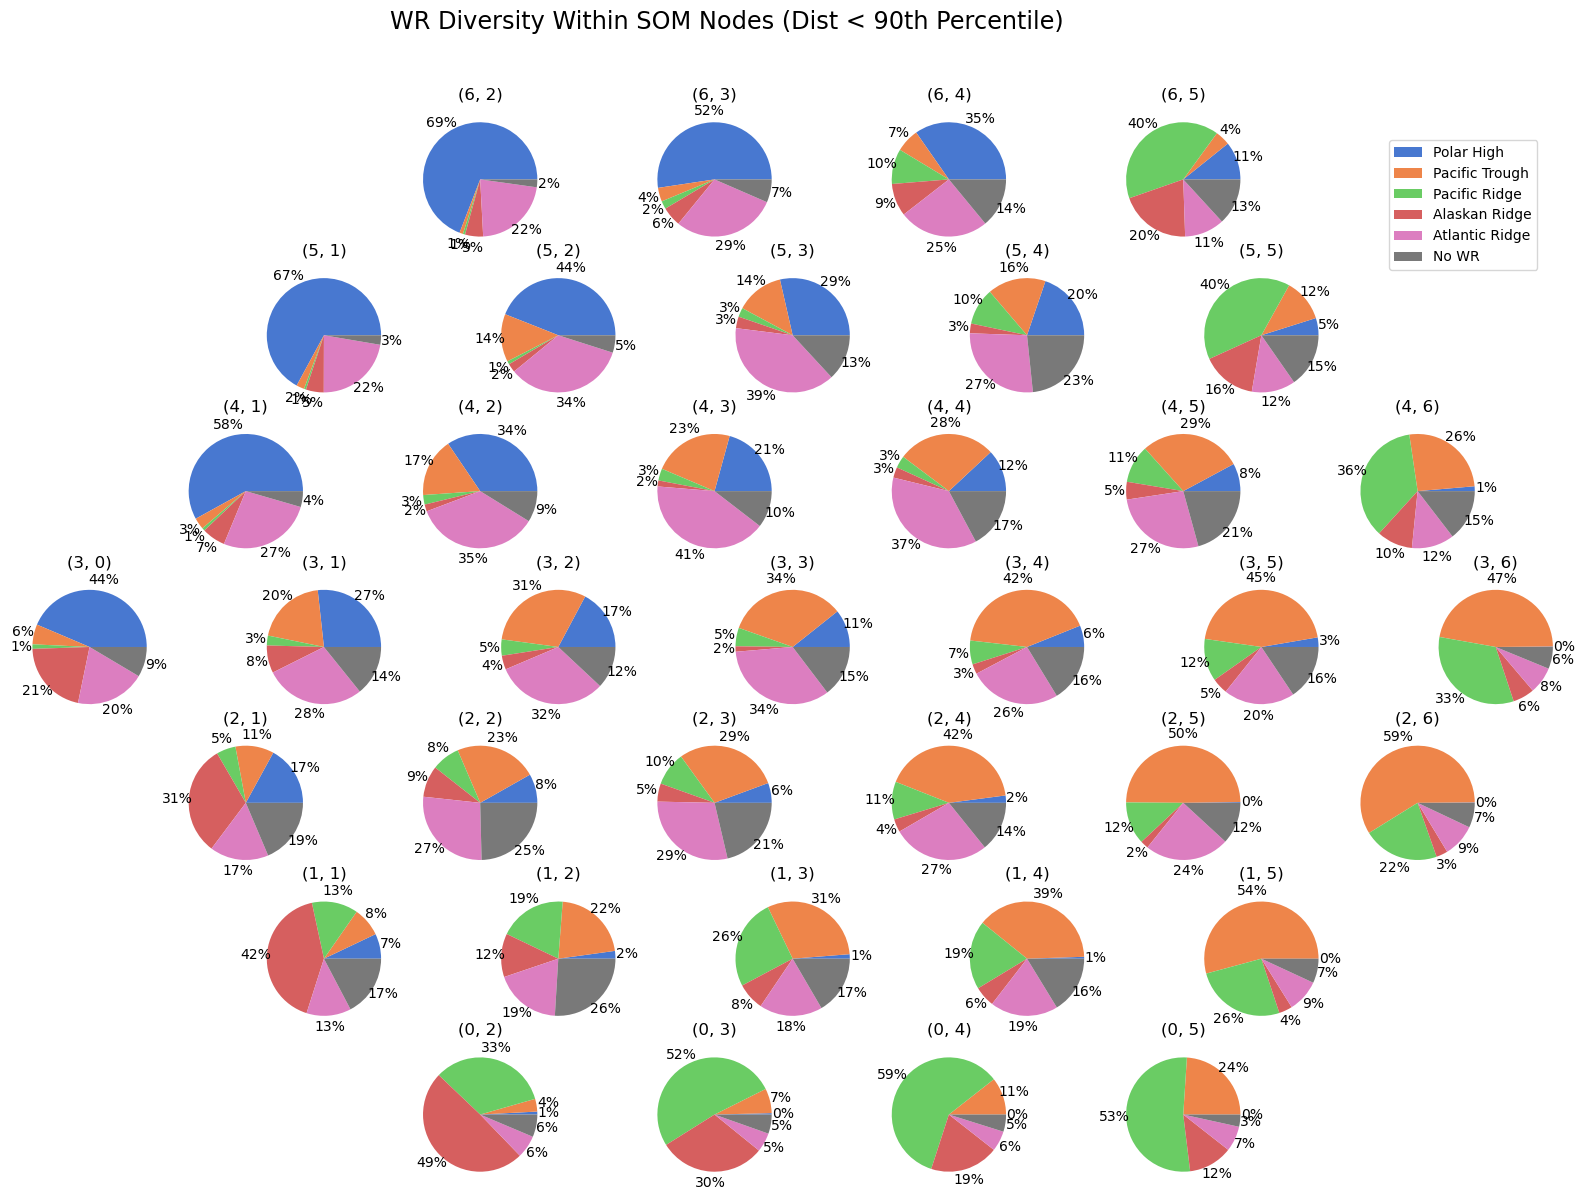

In [21]:
# Change which set of WR data to use
WRs = WRs_by_node
WRs = WRs_lt90
#WRs = WRs_DJF
#WRs = WRs_MAM
#WRs = WRs_JJA
#WRs = WRs_SON

# Create the pie chart plot
fig, axs = hex_plot(som)

for node in node_indices:

    k, v = zip(*WRs[node].items())

    keys = [WR_labels_dict[i] for i in k]

    axs[node[0], node[1]].pie(v, labels=keys, labeldistance=None, autopct='%1.0f%%', pctdistance=1.2, colors=wr_colors)
    axs[node[0], node[1]].set_title(f"{(node[0], node[1])}", fontsize=12)

plt.suptitle("WR Diversity Within SOM Nodes (Dist < 90th Percentile)", y=.95, fontsize='xx-large')
plt.legend(loc=3,  bbox_to_anchor=(0.25, 2., 1, 1))
plt.show()

## Transitions

### Sammon plot

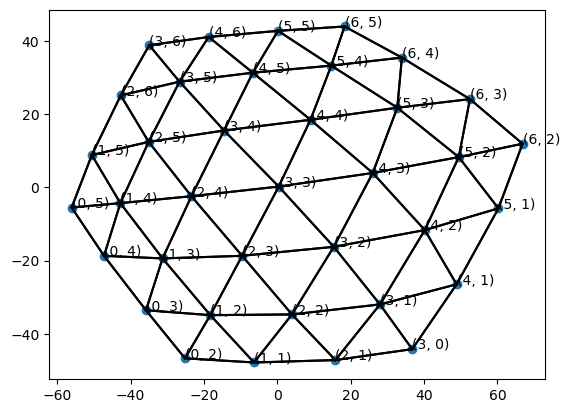

In [9]:
# Find the edges between nodes
edgeCoordinates = []
for i, node in enumerate(node_indices):
    x, y = node
    adj = [(x-1, y), (x+1, y), (x,y-1), (x,y+1)]
    
    if node[0] % 2 == 0:
        adj.append((x+1, y-1))
        adj.append((x-1, y-1))
        
    else:
        adj.append((x+1, y+1))
        adj.append((x-1, y+1))
    
    adj = [(i, node_indices.index((x, y))) for x, y in adj if (x, y) in node_indices]
    edgeCoordinates.extend(adj)

# gets the weights of each node into the order of node_indices
weights = som.get_weights()[node_indices_xy[0], node_indices_xy[1]]

climatology = [0] * inputLength

# Run the Sammon projection
[y,E] = sammon.sammon(weights, 2, display=1)

# Plot the centers of the nodes
plt.scatter(y[:, 0], y[:, 1])

# plot the connections of each node as a line
for s, e in edgeCoordinates:
    plt.plot(y[[s,e], 0], y[[s,e], 1], color='black')

# Label the Nodes
for i, n in enumerate(node_indices):
    plt.annotate(str(n), (y[i, 0], y[i, 1]))

plt.show()

### Calculate transitions

In [9]:
# List of regimes for each day in order
neuronList = []
for i, x in enumerate(dataarray):
    neuronList.append(som.winner(x))

print(len(neuronList))

30660


In [ ]:
# Seasonal break down for the transitions

# Split the seasonal data into each occurance of the given season
def split_seasons_by_occurance(idxs):

    split_indices = np.where(np.diff(idxs) > 1)[0] + 1
    return np.split(idxs, split_indices)

# 2D array of idxs, each array is one seasons worth of days
split_DJF = split_seasons_by_occurance(DJF_idxs)
split_MAM = split_seasons_by_occurance(MAM_idxs)
split_JJA = split_seasons_by_occurance(JJA_idxs)
split_SON = split_seasons_by_occurance(SON_idxs)

# Calculate the transitions for a given season across all years
def calculate_seasonal_transitions(winners, idxs, self_transitions=False):

    # list to store all transitions across all years
    transitions = []
    winners_np = np.array(winners)

    for season_idxs in idxs:
        s_winners = winners_np[season_idxs]
        s_winners = [tuple(row) for row in s_winners]

        # Remove self transitions
        if not self_transitions:
            s_winners = [k for k, g in itertools.groupby(s_winners)]

        # pairs up each value to get list of [first regime, next regime]
        transitions.extend(list(itertools.pairwise(s_winners)))

    # get the counts of each possible transition
    transitions, tcounts = np.unique(transitions, return_counts=True, axis=0)

    # Put the transition counts into a dict and calculate the probabilities
    transitionProbs = {}
    transitionCounts = {}
    # Loop over each node in our SOM
    for i in range(len(node_indices)):
        # Get the indicies of all the transitions that originate from the current node
        neuronIdxs = np.argwhere((transitions[:, 0, 0] == node_indices[i][0]) & (transitions[:, 0, 1] == node_indices[i][1]))
        
        transitionKeys = [tuple(l) for l in transitions[neuronIdxs, 1, :][:, 0, :]]
        transitionCnt = list(tcounts[neuronIdxs][:, 0])
        probabilities = list((tcounts[neuronIdxs] / sum(tcounts[neuronIdxs]))[:, 0])
        transitionProbs[node_indices[i]] = dict(zip(transitionKeys, probabilities))
        transitionCounts[node_indices[i]] = dict(zip(transitionKeys, transitionCnt))

    return transitions, tcounts, transitionCounts, transitionProbs

# Calculates the transition probabilities into a format to be plotted with iGraph
def calculate_transition_probabilities(transitions, probabilities):
    
    prob_list = []

    for t in transitions:

        p = probabilities[(t[0][0], t[0][1])][(t[1][0], t[1][1])]
        prob_list.append(p)
        
    return prob_list

DJF_transitions, DJF_rawcounts, DJF_tcounts, DJF_tprobs = calculate_seasonal_transitions(neuronList, split_DJF)
MAM_transitions, MAM_rawcounts, MAM_tcounts, MAM_tprobs = calculate_seasonal_transitions(neuronList, split_MAM)
JJA_transitions, JJA_rawcounts, JJA_tcounts, JJA_tprobs = calculate_seasonal_transitions(neuronList, split_JJA)
SON_transitions, SON_rawcounts, SON_tcounts, SON_tprobs = calculate_seasonal_transitions(neuronList, split_SON)
        
#DJF_tprobs = calculate_transition_probabilities(DJF_transitions, DJF_tprobs)
#MAM_tprobs = calculate_transition_probabilities(MAM_transitions, MAM_tprobs)
#JJA_tprobs = calculate_transition_probabilities(JJA_transitions, JJA_tprobs)
#SON_tprobs = calculate_transition_probabilities(SON_transitions, SON_tprobs)


In [12]:
print(DJF_transitions.shape)
print(MAM_transitions.shape)
print(JJA_transitions.shape)
print(SON_transitions.shape)

print(sum(DJF_rawcounts)/ 83)
print(sum(MAM_rawcounts)/ 83)
print(sum(JJA_rawcounts)/ 83)
print(sum(SON_rawcounts)/ 83)

(392, 2, 2)
(443, 2, 2)
(461, 2, 2)
(448, 2, 2)
40.34939759036145
43.98795180722892
45.91566265060241
43.144578313253014


In [18]:
color_list = sns.color_palette('hls', len(node_indices))
random.shuffle(color_list)

#color_list = generate_distinct_colors(len(node_indices))

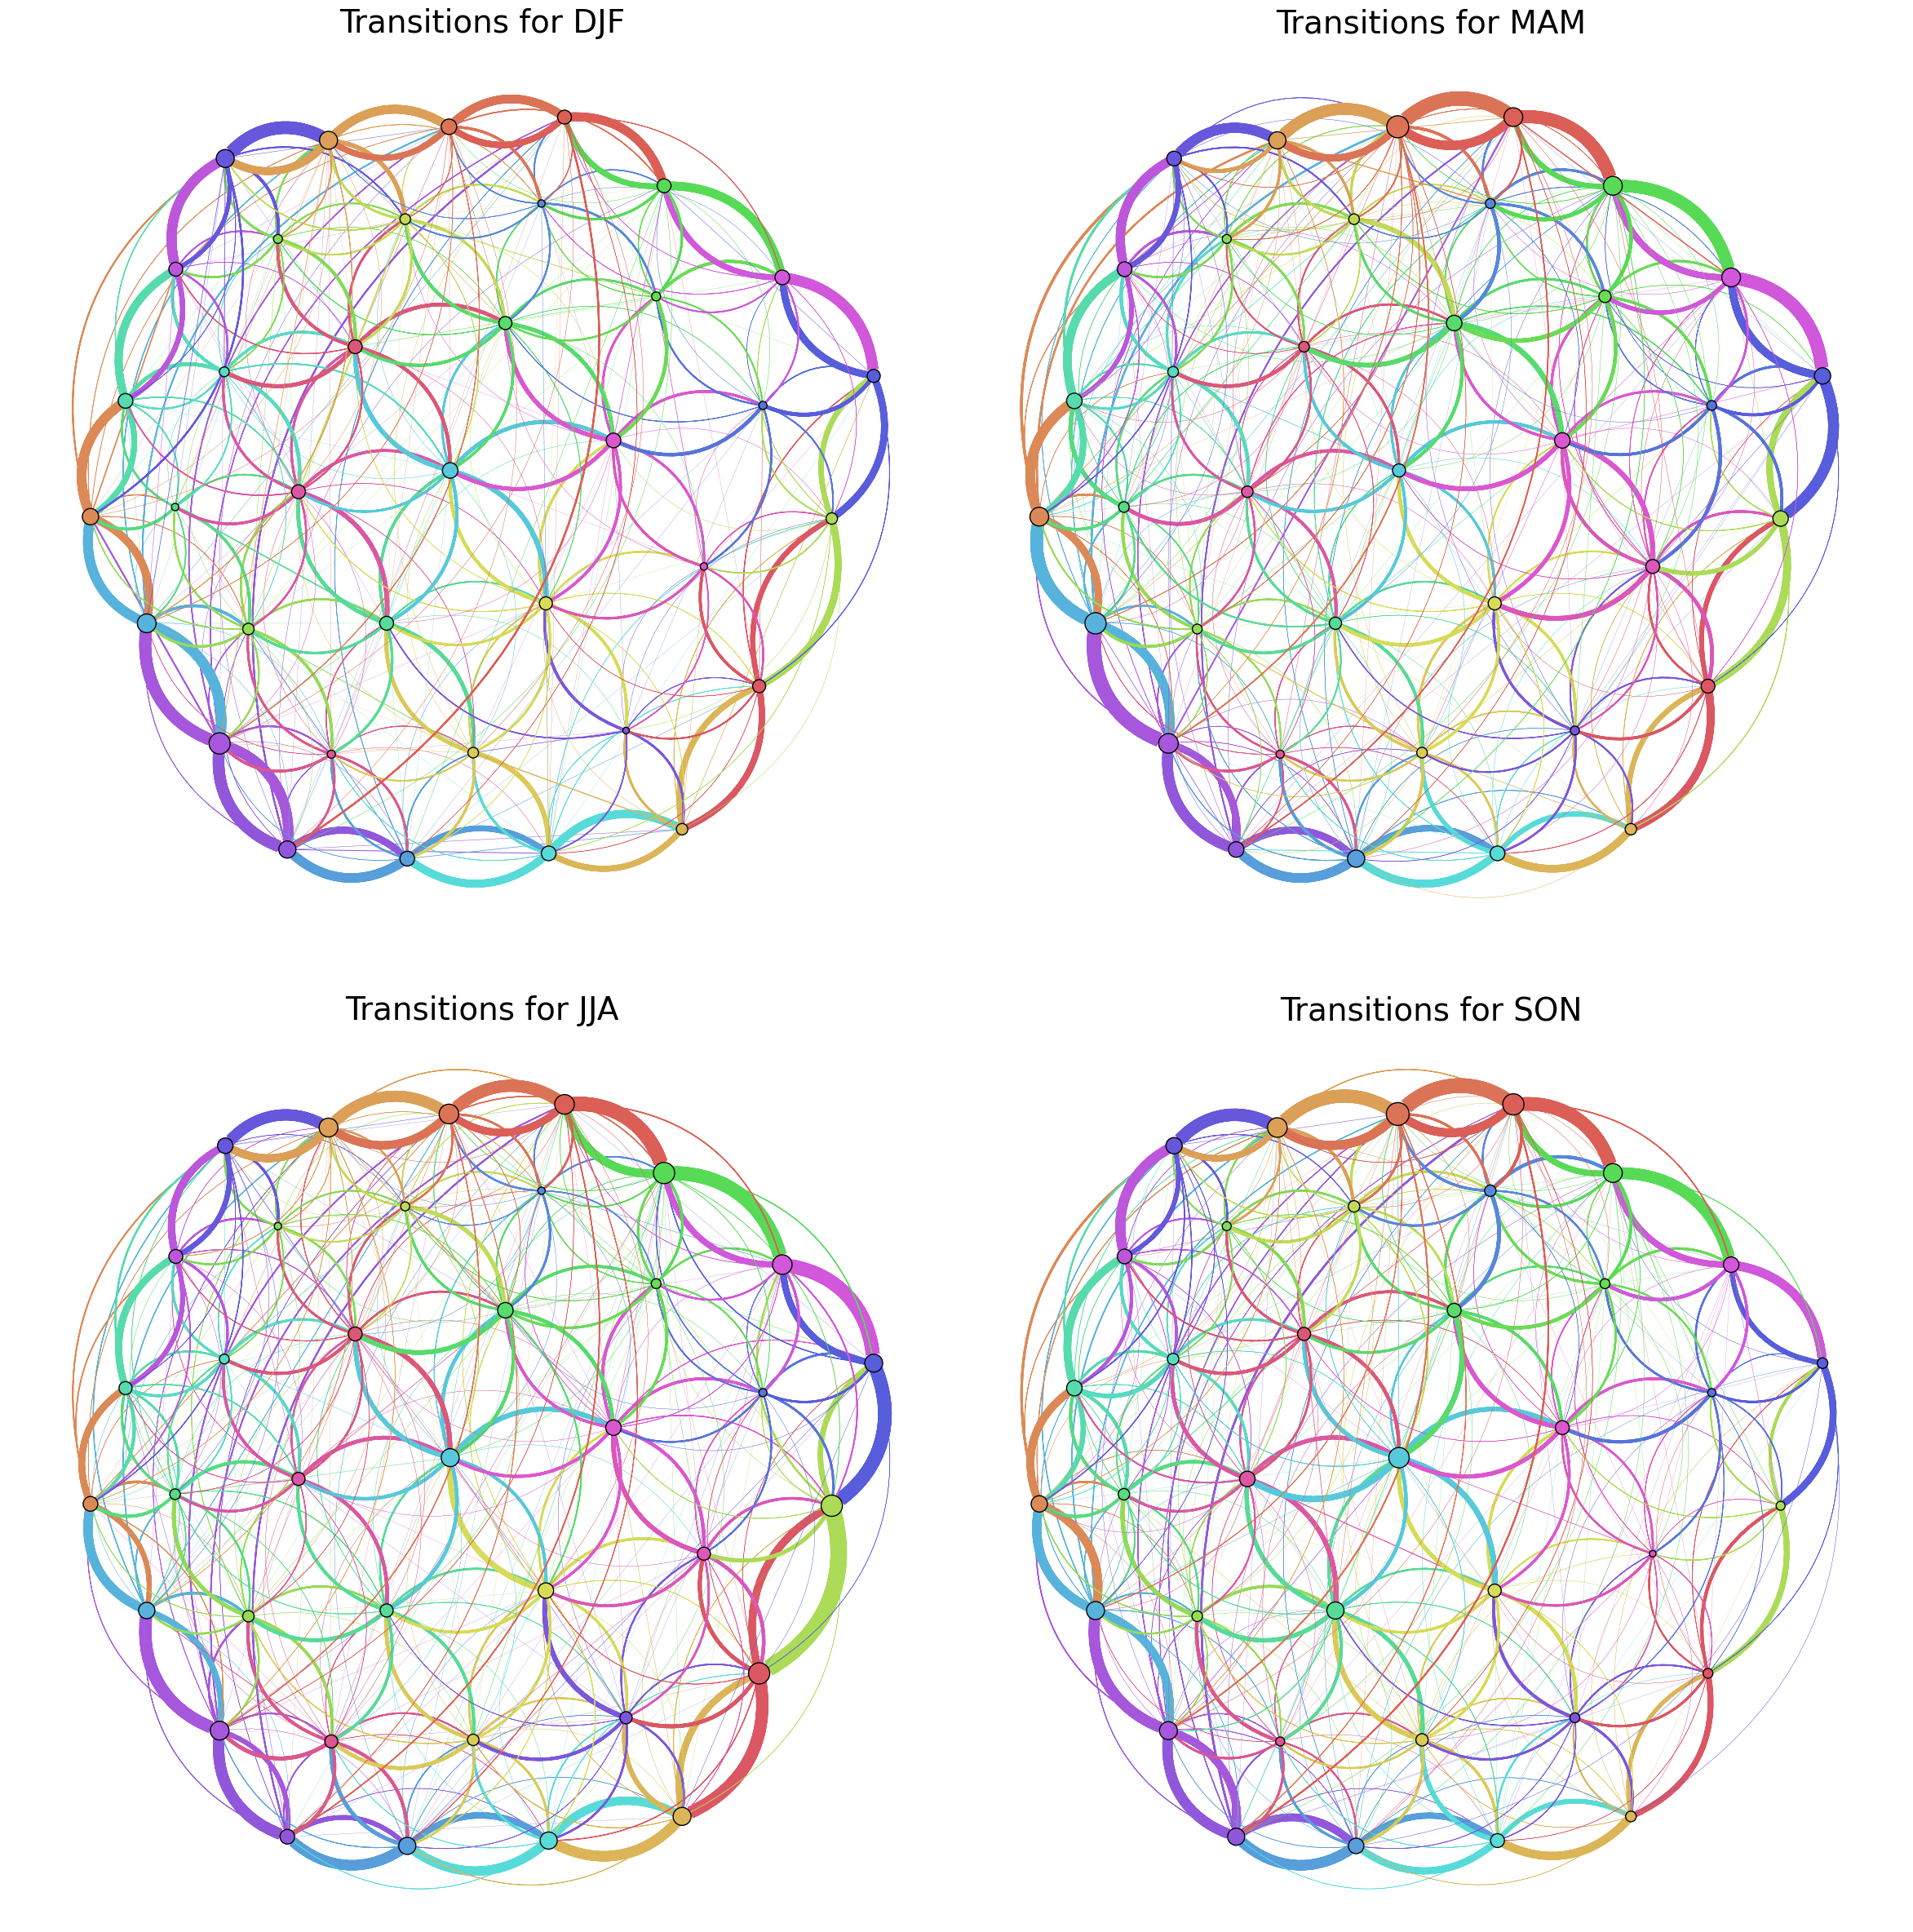

In [53]:
transitions = [(DJF_transitions, DJF_rawcounts, DJF_tcounts), 
               (MAM_transitions, MAM_rawcounts, MAM_tcounts),
               (JJA_transitions, JJA_rawcounts, JJA_tcounts),
               (SON_transitions, SON_rawcounts, SON_tcounts)]
seasonDict = {0: 'DJF', 1: 'MAM', 2: 'JJA', 3: 'SON'}

fig, axs = plt.subplots(2, 2, figsize=(30, 30))

for i in range(4):
    t = transitions [i]
    ax = axs[i // 2, i % 2]
    
    n_verticies = len(node_indices)
    edges = [(node_indices.index(tuple(s)), node_indices.index(tuple(e))) for s, e in t[0]]
    edgeWeights = t[1]
    vertexWeights = [sum(t[2][n].values()) for n in node_indices]
    vertexColors = color_list
    
    # Edge color is the same as the node it originates from
    edgeColors = [color_list[s] for s, e in edges]
    
    g = ig.Graph(n_verticies, edges)
    layout = ig.Layout(coords=y)
    
    ax.set_title(f"Transitions for {seasonDict[i]}", fontsize=28)
    ig.plot(
        g,
        target = ax,
        layout = layout,
        vertex_size = [i * .18 for i in vertexWeights],
        vertex_color = vertexColors,
        edge_width = [i * .18 for i in edgeWeights],
        edge_color = edgeColors
    )
    
plt.subplots_adjust(wspace=0.001, hspace=0.1)
plt.show()

In [45]:
n_verticies = len(node_indices)
edges = [(node_indices.index(tuple(s)), node_indices.index(tuple(e))) for s, e in SON_transitions]
edgeWeights = SON_tprobs
vertexWeights = [sum(SON_tcounts[n].values()) for n in node_indices]
vertexColors = color_list

# Removes all transitions that only happen once
#substantial_transition_idxs = np.array(edgeWeights != 1).nonzero()[0]
#edgeWeightsSubset = edgeWeights[substantial_transition_idxs]
#edgesSubset = np.array(edges)[substantial_transition_idxs]

# Edge color is the same as the node it originates from
edgeColors = [color_list[s] for s, e in edges]


g = ig.Graph(n_verticies, edges)
layout = ig.Layout(coords=y)

fig, ax = plt.subplots(figsize=(10,10))
plt.title("Transition probabilities for SON")
ig.plot(
    g,
    target = ax,
    layout = layout,
    vertex_size = [i * .12 for i in vertexWeights],
    vertex_color = vertexColors,
    edge_width = [i * 18 for i in edgeWeights],
    edge_color = edgeColors
)

TypeError: float() argument must be a string or a real number, not 'tuple'

Error in callback <function _draw_all_if_interactive at 0x000001ECA6AABCE0> (for post_execute), with arguments args (),kwargs {}:


TypeError: float() argument must be a string or a real number, not 'tuple'

TypeError: float() argument must be a string or a real number, not 'tuple'

<Figure size 1000x1000 with 1 Axes>

In [47]:
# groups each continuous strech of a regime together
# COMMENT OUT THE LINE BELOW TO INCLUDE SELF TRANSITIONS
neuronList = [k for k, g in itertools.groupby(neuronList)]

# pairs up each value to get list of [first regime, next regime]
transitions = list(itertools.pairwise(neuronList))

# get the counts of each possible transition
transitions, tcounts = np.unique(transitions, return_counts=True, axis=0)

transitionProbs = {}
transitionCounts = {}
for i in range(len(node_indices)):
    neuronIdxs = np.argwhere((transitions[:, 0, 0] == node_indices[i][0]) & (transitions[:, 0, 1] == node_indices[i][1]))
    
    transitionKeys = [tuple(l) for l in transitions[neuronIdxs, 1, :][:, 0, :]]
    transitionCnt = list(tcounts[neuronIdxs][:, 0])
    probabilities = list((tcounts[neuronIdxs] / sum(tcounts[neuronIdxs]))[:, 0])
    transitionProbs[node_indices[i]] = dict(zip(transitionKeys, probabilities))
    transitionCounts[node_indices[i]] = dict(zip(transitionKeys, transitionCnt))

print(transitionCounts)
print(transitionProbs)

#transitionProbs = calculate_transition_probabilities(transitions, transitionProbs)

{(0, 2): {(0, 3): 217, (0, 4): 14, (1, 1): 132, (1, 2): 23, (1, 3): 6, (2, 1): 8, (2, 2): 3, (2, 3): 1, (3, 0): 3, (3, 2): 1, (4, 1): 1, (4, 6): 2, (5, 5): 9, (6, 2): 1, (6, 3): 1, (6, 4): 3, (6, 5): 33}, (0, 3): {(0, 2): 148, (0, 4): 244, (0, 5): 24, (1, 1): 7, (1, 2): 25, (1, 3): 23, (1, 4): 2, (1, 5): 3, (2, 2): 1, (2, 3): 3, (2, 4): 4, (2, 6): 1, (3, 2): 2, (3, 3): 3, (3, 6): 1, (4, 6): 6, (5, 5): 23, (6, 5): 23}, (0, 4): {(0, 2): 4, (0, 3): 166, (0, 5): 205, (1, 2): 6, (1, 3): 44, (1, 4): 19, (1, 5): 5, (2, 3): 1, (2, 4): 2, (2, 5): 1, (2, 6): 1, (3, 3): 2, (3, 4): 1, (3, 5): 3, (3, 6): 13, (4, 6): 20, (5, 5): 26, (6, 5): 5}, (0, 5): {(0, 3): 8, (0, 4): 142, (1, 3): 8, (1, 4): 38, (1, 5): 167, (2, 4): 4, (2, 5): 5, (2, 6): 21, (3, 4): 1, (3, 5): 2, (3, 6): 40, (4, 4): 1, (4, 6): 18, (5, 5): 9}, (1, 1): {(0, 2): 195, (0, 3): 12, (1, 2): 54, (1, 3): 8, (2, 1): 120, (2, 2): 24, (2, 3): 2, (3, 0): 10, (3, 1): 6, (3, 2): 2, (4, 1): 3, (4, 2): 1, (5, 1): 1, (6, 2): 1, (6, 4): 4, (6, 5):

### Heatmap transition plot

c:\Users\wichr\anaconda3\envs\wr_minisom\Lib\site-packages\matplotlib\transforms.py:2048: UserWarning: Warning: converting a masked element to nan.
  self._mtx[0, 2] += tx
c:\Users\wichr\anaconda3\envs\wr_minisom\Lib\site-packages\matplotlib\transforms.py:2049: UserWarning: Warning: converting a masked element to nan.
  self._mtx[1, 2] += ty


Text(0.5, 0.93, 'All Transtitions')

c:\Users\wichr\anaconda3\envs\wr_minisom\Lib\site-packages\matplotlib\text.py:756: UserWarning: Warning: converting a masked element to nan.
  posx = float(self.convert_xunits(self._x))
c:\Users\wichr\anaconda3\envs\wr_minisom\Lib\site-packages\matplotlib\text.py:757: UserWarning: Warning: converting a masked element to nan.
  posy = float(self.convert_yunits(self._y))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should

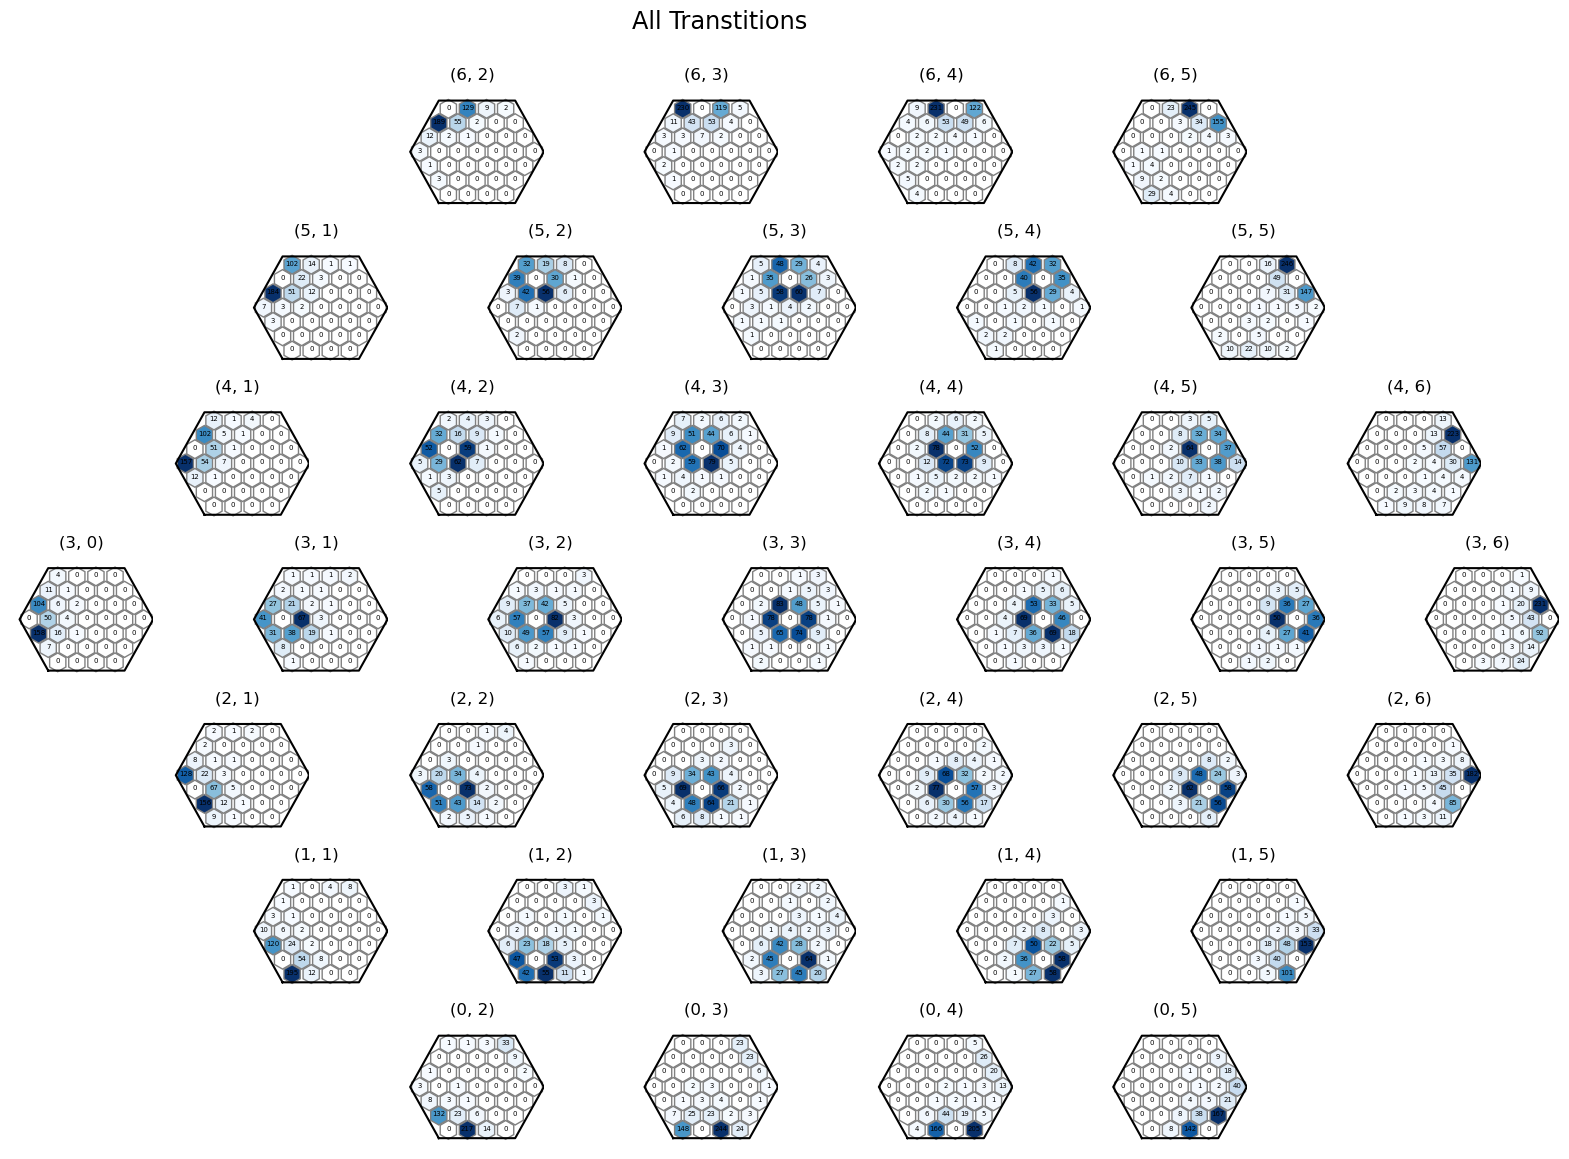

In [22]:
def transition_heatmap(som, data, ax=None):
    # set up the figure
    if ax == None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    
    ax.set_aspect('equal')
    
    # get the coordinates for the hexes
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    maxData = max(data.values())
    
    for x, y in list(product(range(weights.shape[0]), range(weights.shape[0]))):
        if (x, y) in data:
            # determine the color for the hexagon
            colorWeight = data[(x, y)]/maxData
            color = colormaps['Blues'](colorWeight)
            text = float(data[(x, y)])
            
        else:
            # if no daa plot it white
            color = 'white'
            text = 0.0
            
        # determine the hexagon position and color
        wy = yy[(y, x)] * np.sqrt(3) / 2
        
        # Create hexagon and add it to axis
        hex = patches.RegularPolygon((xx[(y, x)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                    facecolor=color, edgecolor='grey')
        ax.add_patch(hex)
        
        # add text to hexagon for its frequency
        ax.text(xx[(y, x)], wy, f'{int(text)}', {'horizontalalignment': 'center'}, fontsize=5)

        
    # align figure to show all hexagons
    ax.set_xlim(-1, weights.shape[0] - .5)
    ax.set_ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    ax.set_xticks([])
    ax.set_yticks([])

    # plot a hexagon around the subplot
    hex_x = [xx[2, 0] - .5, xx[5, 0] + .5, xx[6, 3] + .5, xx[5, 6] + .5, xx[2, 6] - .5, xx[0, 3] - .5, xx[2, 0] - .5]
    hex_y = [yy[2, 0] - .5, yy[5, 0] - .5, yy[6, 3], yy[5, 6] + .5, yy[2, 6] + .5, yy[0, 3], yy[2, 0] - .5]
    hex_y = [i * np.sqrt(3) / 2 for i in hex_y]
    ax.plot(hex_x, hex_y, color='k')

# Create the plot with all subplots
fig, axs = hex_plot(som)

for node in node_indices:
    ax = axs[node[0], node[1]]
    transition_heatmap(som, transitionCounts[node], ax)
    ax.set_axis_off()

plt.suptitle('All Transtitions', y=.93, fontsize='xx-large')

### Sammon transition plot

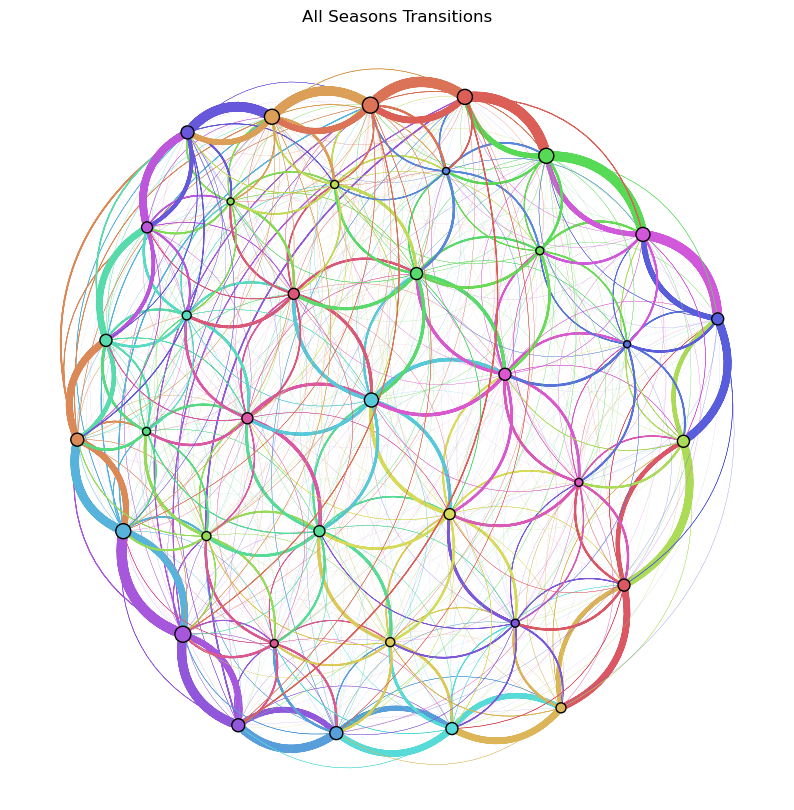

In [49]:
n_verticies = len(node_indices)
edges = [(node_indices.index(tuple(s)), node_indices.index(tuple(e))) for s, e in transitions]
edgeWeights = tcounts
vertexWeights = [sum(transitionCounts[n].values()) for n in node_indices]
vertexColors = color_list

# Removes all transitions that only happen once
#substantial_transition_idxs = np.array(edgeWeights != 1).nonzero()[0]
#edgeWeightsSubset = edgeWeights[substantial_transition_idxs]
#edgesSubset = np.array(edges)[substantial_transition_idxs]

# Edge color is the same as the node it originates from
edgeColors = [color_list[s] for s, e in edges]


g = ig.Graph(n_verticies, edges)
layout = ig.Layout(coords=y)

fig, ax = plt.subplots(figsize=(10,10))
plt.title("All Seasons Transitions")
ig.plot(
    g,
    target = ax,
    layout = layout,
    vertex_size = [i * .03 for i in vertexWeights],
    vertex_color = vertexColors,
    edge_width = [i * .03 for i in edgeWeights],
    edge_color = edgeColors
)


### Trends

In [ ]:
def trend_significance(group, alpha=.05):
    g = list(group)
    slopes = []
    iters = 10000
    
    for i in range(iters):
        samples = []
        for j in range(len(group)):
            samples.extend(random.sample(g, 1))
            
        m = np.polyfit(group.index, samples, 1)[0]
        slopes.append(m)
        
    lower = np.percentile(slopes, (alpha/2) * 100)
    upper = np.percentile(slopes, (1 - alpha/2) * 100)
    
    return lower, upper

In [8]:
sig95 = []
sig90 = []

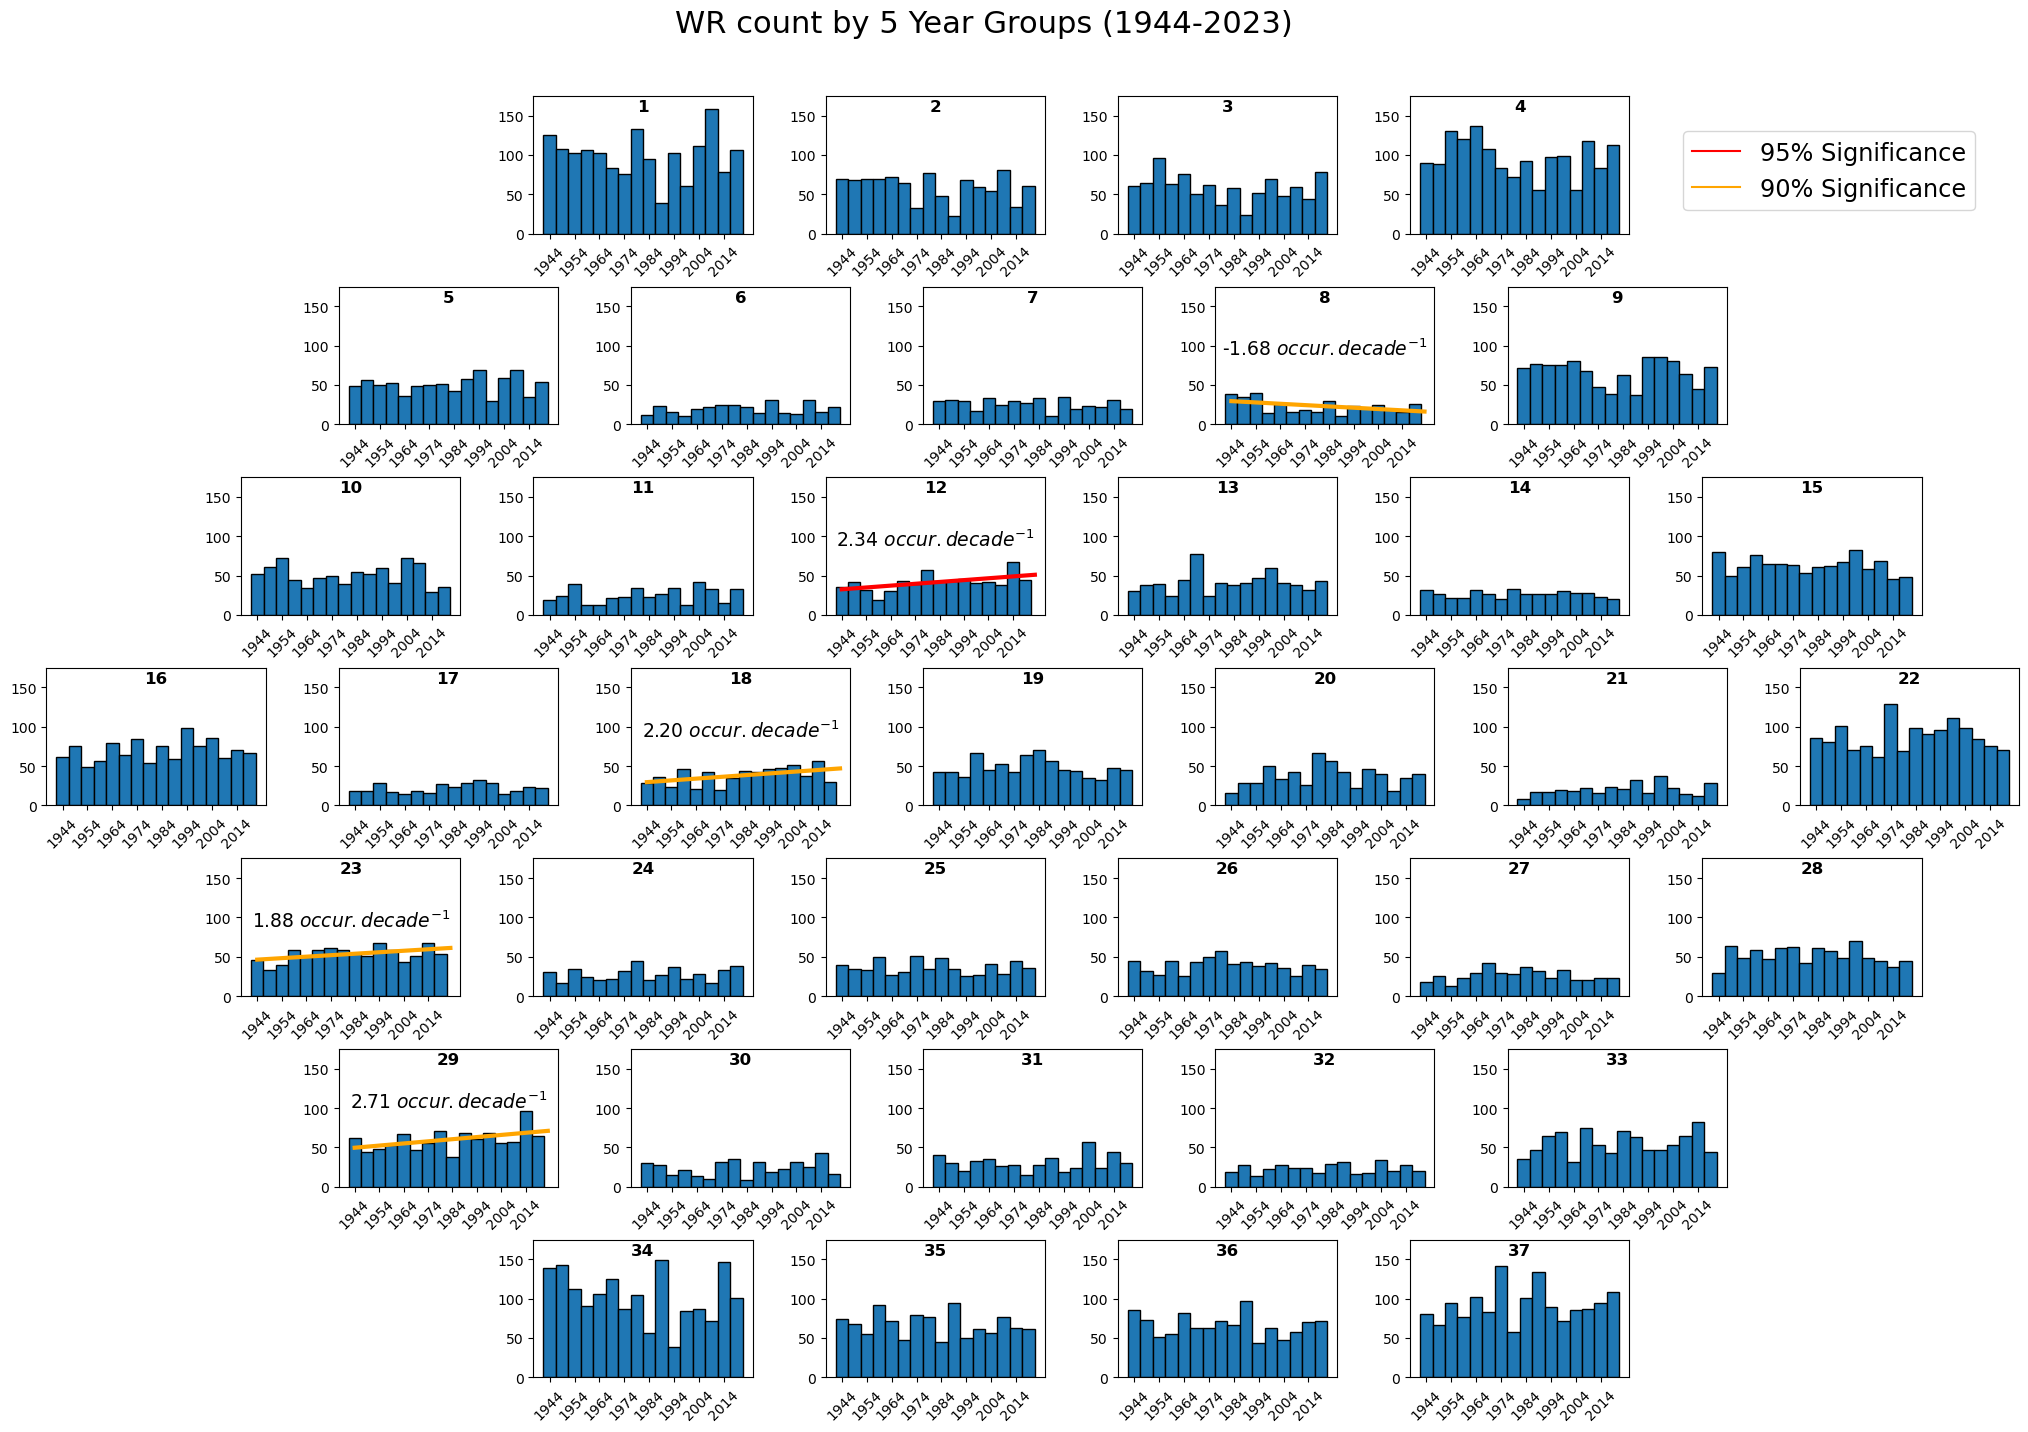

In [42]:
fig, axs = hex_plot(som)
timeData = {}
maxBin = 175

i = 0

for node, indices in winmap.items():
    
    bin_size = 5  #in years
    ax = axs[node[0], node[1]]

    # Get the labels for each of the days grouped into the current node
    dates_labels = WR_labels_df.iloc[indices][['date', 'WR']]
    # Remove the first 4 years of our data for even bins
    dates_labels_truncated = pd.DataFrame(dates_labels[dates_labels['date'].dt.year >= 1944])
    # Make the groups
    dates_labels_truncated['year_group'] = ((dates_labels_truncated['date'].dt.year - 4) // bin_size) * bin_size + 4

    # group by the groups just made
    groups = dates_labels_truncated.groupby('year_group').size()
    
    # Keep track of the largest bin
    if max(groups) > maxBin:
        maxBin = max(groups)

    # Plot the bins as a bar plot
    ax.bar(groups.index, groups, width=bin_size, edgecolor='k')
    
    # Calculate the significance of the trend
    #lower95, upper95 = trend_significance(groups)
    #lower90, upper90 = trend_significance(groups, alpha=.1)
    
    #sig95.append((lower95, upper95))
    #sig90.append((lower90, upper90))
    
    lower95, upper95 = sig95[i]
    lower90, upper90 = sig90[i]
    i += 1
    
    # Calculate the trend of the actual data
    z = np.polyfit(groups.index, groups, 1)
    
    # Plot trend only if it is significant
    if z[0] >= upper90 or z[0] <= lower90:
        p = np.poly1d(z)
        x = np.arange(groups.index[0], groups.index[-1] + bin_size)
        y = p(x)
        
        if node == (1, 1):
            ax.text(.5, .57, f'{z[0]*10:.2f} ' + '$occur. decade^{-1}$', transform=ax.transAxes, ha='center', fontdict={'fontsize': 13.5})
        else:
            ax.text(.5, .50, f'{z[0]*10:.2f} ' + '$occur. decade^{-1}$', transform=ax.transAxes, ha='center', fontdict={'fontsize': 13.5})
        
        # Plot with different colors depending on significance
        if z[0] >= upper95 or z[0] <= lower95:
            color = 'r'
        else:
            color = 'orange'
            
        ax.plot(x, y, c=color, linewidth=3)
        
    ax.set_xticks(groups.index[::2])
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(node_nums[node], y=.83, fontdict={'fontweight': 'bold'})
    
# Loop through each axis to change y axis scale
for node in node_indices:
    axs[node[0], node[1]].set_ylim(0, maxBin)

plt.suptitle("WR count by 5 Year Groups (1944-2023)", y=1.02, fontsize=22)
fig.tight_layout()

# Create dummy data so a legend can be made for the significance
plt.plot([1944], [0], color='r', label='95% Significance')
plt.plot([1944], [0], color='orange', label='90% Significance')
plt.legend(loc='upper right', bbox_to_anchor=(.30, 2.6, 1, 1), fontsize='xx-large')

plt.subplots_adjust(wspace=-.2, hspace=1.25)

plt.savefig('pdf_output/WR_count_trends.pdf', bbox_inches='tight')